In [1]:
import pandas as pd
import gzip
import json


import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

C:\Users\lenpk\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [2]:
# train dataset
train = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")
test= pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [3]:
# Combine datasets
train['train'] = 1
test['test'] = 0

In [4]:
combined = pd.concat([train, test]).reset_index(drop = True)

In [5]:
# Fill nan values with 'unknown'
combined['Location'].fillna('Unknown', inplace = True)

C:\Users\lenpk\anaconda3\envs\PythonAdv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


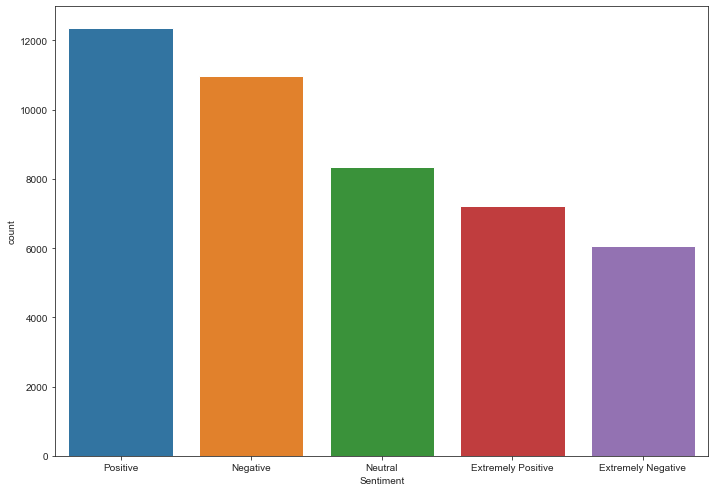

In [6]:
# Plot sentiment data
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.countplot(combined['Sentiment'], order=combined['Sentiment'].value_counts(ascending=False).index, ax=ax)
plt.show()

In [7]:
combined.replace({'Extremely Positive': 'Positive', 'Extremely Negative': 'Negative'}, inplace = True)

In [9]:
ml_data_filtered =combined.loc[(combined['Sentiment'] == 'Positive') | (combined['Sentiment'] == 'Negative')].reset_index(drop = True)

In [10]:
# rename columns to class and text
df = ml_data_filtered.rename(columns = {'OriginalTweet': 'text', 'Sentiment': 'class'})
df.head()

,UserName,ScreenName,Location,TweetAt,text,class,train,test
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,1.0,NaN
1,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,1.0,NaN
2,3802,48754,Unknown,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,1.0,NaN
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Negative,1.0,NaN
4,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive,1.0,NaN


In [11]:
from io import StringIO

df['class_id'] = df['class'].factorize()[0]
class_id_df = df[['class', 'class_id']].drop_duplicates().sort_values('class_id')
class_to_id = dict(class_id_df.values)
id_to_class = dict(class_id_df[['class_id', 'class']].values)
df.tail()

,UserName,ScreenName,Location,TweetAt,text,class,train,test,class_id
36618,3793,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call on the General Assembly to enact a legal stay against debt collection activities now that thousands of Marylanders are without a paycheck? \r\r\n\r\r\nhttps://t.co/6JKuOOjXvN",Negative,NaN,0.0,1
36619,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People dance and sing together to stay positive. ? #CoronaVirus https://t.co/VLLqGI3R16,Positive,NaN,0.0,0
36620,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable items? ECHO needs food donations. It is also looking for volunteers to pack boxes. Volunteers will be screened to be sure they don't have COVID-19. https://t.co/TST4Vjhbu4,Negative,NaN,0.0,1
36621,3797,48749,Unknown,16-03-2020,Gov need to do somethings instead of biar je rakyat assume 'lockdown' ke or even worst. Harini semua supermarket crowded like hell. Lagi mudah virus tu tersebar ?? #COVID2019,Negative,NaN,0.0,1
36622,3798,48750,"Arlington, Virginia",16-03-2020,I and @ForestandPaper members are committed to the safety of our employees and our end-users. We are monitoring COVID-19. Rest assured that tissue manufacturers are continuing to produce and ship products. https://t.co/qF6hclCAEq https://t.co/xyvbNsFeXA,Positive,NaN,0.0,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

In [32]:
labels = df['class'].unique()

In [13]:
# Count Vectorizer
cnt_vec = CountVectorizer()
cnt_vec.fit(df['text'])
text_cnt_vec = cnt_vec.transform(df['text'])


In [14]:
tfidf_transformer = TfidfTransformer()
text_tfidf = tfidf_transformer.fit_transform(text_cnt_vec)

In [15]:
X_train = text_tfidf[df['train'] == 1]
X_test = text_tfidf[df['test'] == 0]

y_train = df['class_id'][df['train'] == 1]
y_test = df['class_id'][df['test'] == 0]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33444, 71738), (3179, 71738), (33444,), (3179,))

In [41]:
clf = LogisticRegression(max_iter = 1000)

In [42]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [43]:
score = clf.score(X_test, y_test)

In [44]:
print("Accuracy:", score)

Accuracy: 0.8398867568417742


In [20]:
clf_lvc = LinearSVC()

In [21]:
clf_lvc.fit(X_train, y_train)

LinearSVC()

In [22]:
score_lvc = clf_lvc.score(X_test, y_test)

In [30]:
lvc_pred = clf_lvc.predict(X_test)
lvc_pred

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [23]:
print("Accuracy:", score_lvc)

Accuracy: 0.8716577540106952


In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
rf_score = rf.score(X_test, y_test)
print("Accuracy:", rf_score)

Accuracy: 0.758414595784838


In [26]:
clf_nb = MultinomialNB()

In [27]:
clf_nb.fit(X_train, y_train)

MultinomialNB()

In [28]:
clf_score = clf_nb.score(X_test, y_test)
print("Accuracy:", clf_score)

Accuracy: 0.7433155080213903


In [128]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000]}  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.848, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... C=0.1, score=0.852, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.847, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.855, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.850, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.870, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.877, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.874, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.877, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.882, total=   0.4s
[CV] C=10 ............................................................
[CV] .

C:\Users\lenpk\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............................... C=100, score=0.842, total=   4.7s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.852, total=   4.8s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.848, total=   5.1s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.849, total=   6.1s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.855, total=   6.9s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.840, total=   6.2s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.850, total=   6.5s
[CV] C=1000 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.1, 1, 10, 100, 1000]},
             verbose=3)

In [127]:
print(clf_lvc.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


In [129]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


{'C': 1}
LinearSVC(C=1)


In [131]:
from sklearn.metrics import classification_report, confusion_matrix 
grid_predictions = grid.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1546
           1       0.89      0.86      0.87      1633

    accuracy                           0.87      3179
   macro avg       0.87      0.87      0.87      3179
weighted avg       0.87      0.87      0.87      3179



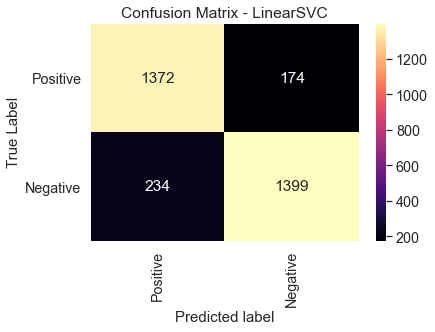

<Figure size 720x504 with 0 Axes>

In [33]:
#import the relevant packages
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
#get the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,  
                                            lvc_pred)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - LinearSVC')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(['']+labels, rotation = 90)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

In [52]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix 

In [48]:
# Logistic Regression Gridsearch
grid_values = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_lr = GridSearchCV(clf, param_grid=grid_values)

In [49]:
grid_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']})

In [50]:
# print best parameter after tuning 
print(grid_lr.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid_lr.best_estimator_) 

{'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10, max_iter=1000)


In [53]:
grid_lr_predictions = grid_lr.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_lr_predictions)) 

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1546
           1       0.89      0.85      0.87      1633

    accuracy                           0.87      3179
   macro avg       0.87      0.87      0.87      3179
weighted avg       0.87      0.87      0.87      3179



In [ ]:
# Grid search for linearSVC
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000]}  
  
grid_lvc = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 